# ECSE 415: Final Project
Mathieu Geoffroy, 260986559
Ryan Reszetnik, 260948454


December 5th, 2023

In [36]:
import numpy as np
import cv2
import os
from ultralytics import YOLO
import torch
from collections import defaultdict

working_dir = os.path.curdir

![image.png](image.png)

To calculate the speed of cars, we assume the math based on a top-down view as seen above. This assumes everything is at eye level and the same distance away from the car which is a simplification but seems to give good enough results.

Math to derrive equation used in code:

Want to find Z(B,C)
C = distance from centre of screen
B = velocity of object in pixels
Z = real object velocity


(D+Y)/(A+B+C)=D/(B+C)
D+Y = (A+B+C)*D/(B+C)
Y= (A+B+C)*D/(B+C)-D

(D+Y+Z)/(A+B+C) = D/C
Y+Z=(A+B+C)*D/C-D

Subtract two equations

Z=((A+B+C)*D/C-D) - ((A+B+C)*D/(B+C)-D)

Z= (A+B+C)*D/C-(A+B+C)*D/(B+C)

Z= (A+B+C)*D*(1/C-1/(B+C))
Z= (A+B+C)*D*B/(C(B+C))

A+B+C —> about equals A 

Z about proportional to: A*B/(C^2+CB)

assume A is constant however in theory could get in terms of distance

Z about proportional to: B/(C^2+CB) <= what we use in our code

## Detecitng moving vs parked

Now that we have an approximate speed for each object in the frame, we take all stationary objects and do a moving average to calculate an approximate speed (we start the speed at 30 as the car is moving to begin with in both videos). This is constantly updated every frame by both parked cars as well as fire hydrants as they don't move and are approximately eye level. To determine if a car is parked or moving, we check the speed of the car compared to the estimated speed. If its more than 1.5x the speed then it's classified as moving otherwise stopped. Any stopped cars go into calculating the speed for the next frame (moving average based on the current estimated speed and the speed of each object in the frame). Fire hydrants are weighted slightly more as they are known to be stopped.
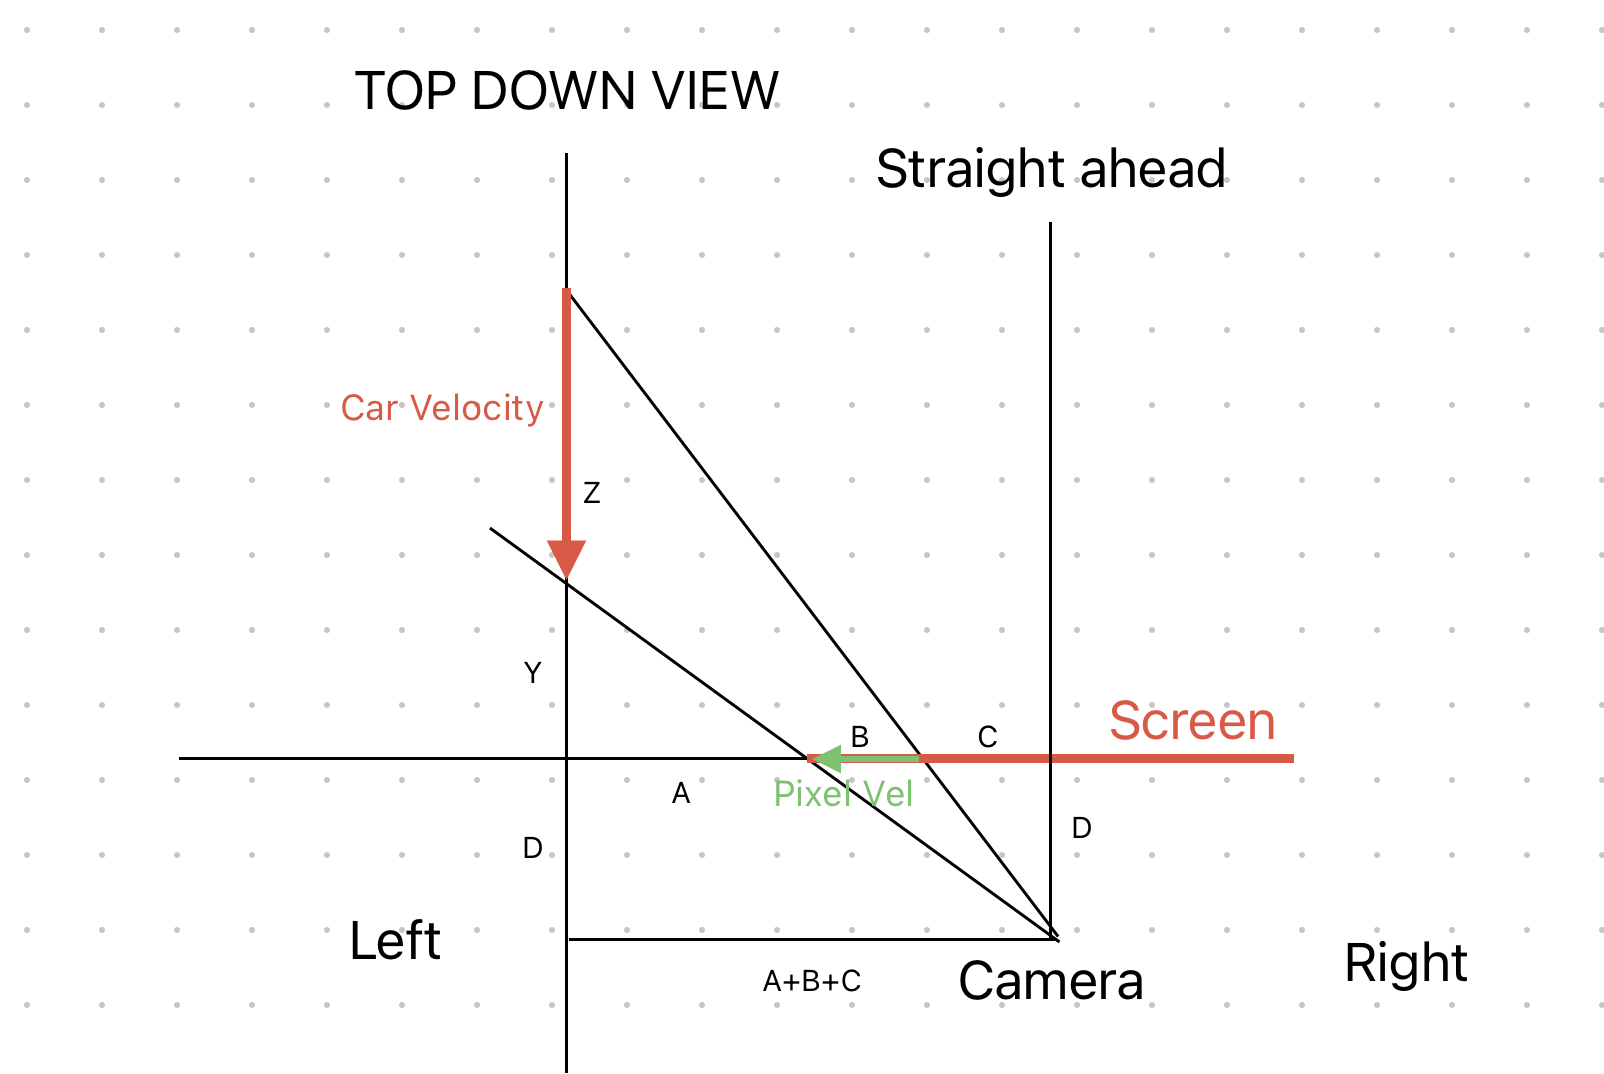

In [54]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model = YOLO('yolov8x.pt').to(device)

# import YOLO labels from the dataset
yolo_labels = model.names

FRAME_SIZE = (1440, 2562) # (height, width)

In [55]:
def get_actual_speed(positions):
    new_pos = []
    for i in range(len(positions)):
        new_pos.append((positions[i][0].numpy(),positions[i][1].numpy()))
    new_pos = np.array(new_pos)
    speed = []
    for j in range(len(new_pos)-1):
        speed.append(np.sqrt((new_pos[j][0]-new_pos[j+1][0])**2+(new_pos[j][1]-new_pos[j+1][1])**2))
    speed = np.array(speed)
    new_pos = 1250-new_pos[:-1,0]
    speed = speed/(new_pos**2+abs(new_pos*speed)) * 1000000
    #median filter of size 3
    median_speed = []
    median_size = 5
    if len(speed) < median_size:
        return np.mean(speed)
    for i in range(len(speed)-median_size+1):
        median_speed.append(np.median(speed[i:i+median_size]))
    median_speed = np.array(median_speed)
    return np.mean(median_speed)


def is_moving(speed,predicted_speed):
    return speed > 1.5*predicted_speed

In [59]:
# Open the video file
def analyze_video(video_path, display=True, save=True):
    print(f"Analyzing video {video_path}...")
    total_start = cv2.getTickCount()
    
    cap = cv2.VideoCapture(video_path)

    video_name = video_path.split('/')[-1].split('.')[0]

    out = cv2.VideoWriter(f'{video_name}_analyzed.mp4',cv2.VideoWriter_fourcc('m','p','4','v'), 30, (int(cap.get(3)),int(cap.get(4))))

    # Store the track history
    track_history = defaultdict(lambda: [])
    moving_history = defaultdict(lambda: [])

    people_count = 0
    predicted_speed = 30
    max_speed = 0

    # Loop through the video frames
    frame_count = 0

    while cap.isOpened():
        start = cv2.getTickCount()
        # Read a frame from the video
        success, frame = cap.read()
        frame_count += 1

        if success:
            # Run YOLOv8 tracking on the frame, persisting tracks between frames
            results = model.track(frame, persist=True,verbose=False)

            # Get the boxes, masks, track IDs, class, for the frame
            boxes = results[0].boxes.xywh.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()
            classes = results[0].boxes.cls.int().cpu().tolist()
            
            # Visualize the results on the frame
            annotated_frame = results[0].plot()

            # For each object in the frame
            for box,track_id,cls in zip(boxes, track_ids,classes):
                # count the people
                if yolo_labels[cls] == 'person' and track_id not in track_history:
                    people_count += 1
                
                x, y, w, h = box
                track = track_history[track_id]
                track.append((x, y))  # x, y center point
                if len(track) > 30:  # retain 90 tracks for 90 frames
                    track.pop(0)
                    
                # detect if the bounding box is touching the edge of the frame   
                touching_edge =  x-w/2 <10 or x+w/2 > FRAME_SIZE[1] or y-h/2 < 0 or y+h/2 > FRAME_SIZE[0]
                
                # get the speed of the object
                obj_speed = get_actual_speed(track)
                
                # update the predicted speed for known stationary objects (to determine the speed of our car)
                if  yolo_labels[cls] == 'fire hydrant' and not np.isnan(obj_speed) and not touching_edge:
                    predicted_speed = 29/30 * predicted_speed + 1/30 * obj_speed
                    
                # set obj_speed to zero if it is Nan
                if np.isnan(obj_speed):
                    obj_speed = 0
                
                # determine if the object is moving or not
                moving_pred = is_moving(obj_speed,predicted_speed)
                
                if yolo_labels[cls] == 'car':
                    moving_history[track_id] = moving_pred
                if obj_speed > 0 and not moving_pred and not np.isnan(obj_speed) and not touching_edge:
                    predicted_speed = 59/60 * predicted_speed + 1/60 * obj_speed

                if yolo_labels[cls] == 'car':
                    text = "moving" if moving_pred else "parked"
                    cv2.putText(annotated_frame, text, (int(x-w/2), int(y+h/2)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

            # count the number of moving and parked cars
            num_moving = 0
            num_parked = 0
            for track_id in moving_history:
                if moving_history[track_id]:
                    num_moving += 1
                else:
                    num_parked += 1
            
            # make transparent box in top left corner
            annotated_frame[0:225,0:625,:] = 0.5*annotated_frame[0:225,0:625,:] + 0.5*np.ones((225,625,3),dtype=np.uint8)
            
            
            
            # Display the number of people
            cv2.putText(annotated_frame, f"Number of people: {people_count}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Display the number of moving cars
            cv2.putText(annotated_frame, f"Number of moving cars: {num_moving}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Display the number of parked cars
            cv2.putText(annotated_frame, f"Number of parked cars: {num_parked}", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Display the predicted speed with 2 decimal places
            cv2.putText(annotated_frame, f"Approximate speed: {predicted_speed:.2f} km/h", (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
            # Display the annotated frame to the user
            cv2.imshow(f'Tracking {video_name}', annotated_frame) if display else None

            # update max speed
            max_speed = max(max_speed, predicted_speed)

            # save the annotated frame to a new video
            out.write(annotated_frame) if save else None
            
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

            end = cv2.getTickCount()
            print(f"Frame {frame_count} in {(end-start)/cv2.getTickFrequency()}s")

        else:
            # Break the loop if the end of the video is reached
            break

    # Release the video capture object and close the display window
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    total_end = cv2.getTickCount()

    print(f"\n\nVideo {video_name} analyzed successfully in {(total_end-total_start)/cv2.getTickFrequency()} seconds")
    print(f"Number of people: {people_count}")
    print(f"Number of moving cars: {num_moving}")
    print(f"Number of parked cars: {num_parked}")
    print(f"Approximate max speed: {max_speed:.2f} km/h")

In [60]:
analyze_video(working_dir + '/mcgill_drive.mp4', display=True, save=True)

Analyzing video ./mcgill_drive.mp4...
Frame 1 in 0.308448667s
Frame 2 in 0.184846084s
Frame 3 in 0.175081833s
Frame 4 in 0.176267833s
Frame 5 in 0.172233s
Frame 6 in 0.171097958s
Frame 7 in 0.18311925s
Frame 8 in 0.158145125s
Frame 9 in 0.173984459s
Frame 10 in 0.176442334s
Frame 11 in 0.172566417s
Frame 12 in 0.158631292s
Frame 13 in 0.167103125s
Frame 14 in 0.17353s
Frame 15 in 0.16241175s
Frame 16 in 0.170529375s
Frame 17 in 0.169834708s
Frame 18 in 0.195307833s
Frame 19 in 0.166932791s
Frame 20 in 0.161749083s
Frame 21 in 0.168058917s
Frame 22 in 0.176844458s
Frame 23 in 0.165192625s
Frame 24 in 0.173299959s
Frame 25 in 0.16494175s
Frame 26 in 0.173661s
Frame 27 in 0.173858583s
Frame 28 in 0.177913375s
Frame 29 in 0.182960375s
Frame 30 in 0.174644s
Frame 31 in 0.174706167s
Frame 32 in 0.173932375s
Frame 33 in 0.172438916s
Frame 34 in 0.167658625s
Frame 35 in 0.164550208s
Frame 36 in 0.183070042s
Frame 37 in 0.161674375s
Frame 38 in 0.174249917s
Frame 39 in 0.163518292s
Frame 40 in 

In [61]:
analyze_video(working_dir + '/st-catherines_drive.mp4', display=True, save=True)

Analyzing video ./st-catherines_drive.mp4...
Frame 1 in 0.236907375s
Frame 2 in 0.185530375s
Frame 3 in 0.17746025s
Frame 4 in 0.177855s
Frame 5 in 0.174190417s
Frame 6 in 0.181658916s
Frame 7 in 0.166798458s
Frame 8 in 0.176897083s
Frame 9 in 0.168816209s
Frame 10 in 0.176775792s
Frame 11 in 0.172854584s
Frame 12 in 0.171672333s
Frame 13 in 0.178690125s
Frame 14 in 0.165326583s
Frame 15 in 0.17600575s
Frame 16 in 0.175158959s
Frame 17 in 0.160764209s
Frame 18 in 0.173994917s
Frame 19 in 0.170125584s
Frame 20 in 0.17452825s
Frame 21 in 0.170711875s
Frame 22 in 0.172074333s
Frame 23 in 0.167872209s
Frame 24 in 0.166682958s
Frame 25 in 0.172863333s
Frame 26 in 0.171864917s
Frame 27 in 0.173842292s
Frame 28 in 0.177115417s
Frame 29 in 0.178362584s
Frame 30 in 0.173767084s
Frame 31 in 0.175179792s
Frame 32 in 0.184299333s
Frame 33 in 0.203233208s
Frame 34 in 0.174836417s
Frame 35 in 0.171395666s
Frame 36 in 0.178874334s
Frame 37 in 0.165187291s
Frame 38 in 0.169614542s
Frame 39 in 0.168454